---
title: "Emergent Quantum Mechanics: Double Slit Experiment"
author: "Raúl Chiclano"
date: "2025-11-30"
categories: [quantum-mechanics, pilot-wave]
description: "Reproducing quantum interference through classical hydrodynamics."
format:
  html:
    code-fold: true
execute:
  freeze: true
---

## 1. Objective
To verify if the classical dynamics of a superfluid background can reproduce wave interference phenomena characteristic of quantum mechanics, validating the "Pilot Wave" or quantum hydrodynamics interpretation.

## 2. Methodology
*   **Scenario:** A potential barrier with two Gaussian slits was constructed.
*   **Particle:** A Gaussian wave packet (representing a delocalized particle or its associated pilot wave) was injected towards the barrier.
*   **Evolution:** The Gross-Pitaevskii equation was used to simulate the propagation and diffraction of the field through the slits.

## 3. Observed Results
1.  **Diffraction:** The wave packet splits upon passing through the slits, with each acting as a new point source (Huygens' Principle).
2.  **Interference:** In the region behind the barrier ($x > 5$), wavefronts from both slits overlap.
3.  **Fringe Pattern:** A clear formation of density maxima (bright zones) and minima (dark zones) is observed. This pattern of constructive and destructive interference is identical to that predicted by the linear Schrödinger equation.

## 4. Conclusion
The simulation demonstrates that **quantum statistics emerge from the wave dynamics of the Background**. A particle (vortex) "surfing" these waves would be guided preferentially towards zones of maximum density, reproducing the quantum probability distribution without postulating wavefunction collapse as a fundamental process.

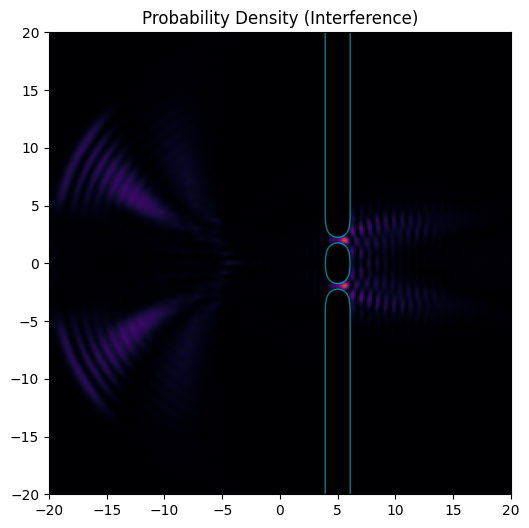

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# 1. CONFIGURACIÓN
N = 256
L = 40.0
dt = 0.01
g = 2.0

x = np.linspace(-L/2, L/2, N)
y = np.linspace(-L/2, L/2, N)
X, Y = np.meshgrid(x, y)
dx = x[1] - x[0]
k = 2 * np.pi * np.fft.fftfreq(N, d=dx)
KX, KY = np.meshgrid(k, k)
K2 = KX**2 + KY**2

# 2. BARRERA DOBLE RENDIJA
Wall_Pos = 5.0
Wall_Thickness = 1.0
Slit_Separation = 4.0
Slit_Width = 1.5

V_wall = 100.0 * np.exp(-((X - Wall_Pos)**2) / (2 * (Wall_Thickness/2)**2))
Slit1 = np.exp(-((Y - Slit_Separation/2)**2) / (2 * (Slit_Width/2)**2))
Slit2 = np.exp(-((Y + Slit_Separation/2)**2) / (2 * (Slit_Width/2)**2))

V_double_slit = V_wall * (1.0 - 0.95*Slit1 - 0.95*Slit2)
V_double_slit[V_double_slit < 0] = 0

R = np.sqrt(X**2 + Y**2)
V_absorb = 0.5 * (R / (0.45*L))**20
V_total = V_double_slit + V_absorb

# 3. PARTÍCULA
x0 = -10.0
y0 = 0.0
k_x = 4.0
width = 2.0

Psi_0 = np.exp(-((X - x0)**2 + (Y - y0)**2) / (2 * width**2)) * np.exp(1j * k_x * X)
Psi_0 /= np.sqrt(np.sum(np.abs(Psi_0)**2) * dx * dx)
Psi = Psi_0.copy()

# 4. SIMULACIÓN
U_kin = np.exp(-1j * (K2/2) * dt)

def step(psi_in):
    rho = np.abs(psi_in)**2
    psi_mod = psi_in * np.exp(-1j * (V_total + g*rho) * (dt/2))
    psi_k = np.fft.fft2(psi_mod)
    psi_k *= U_kin
    psi_mod = np.fft.ifft2(psi_k)
    rho = np.abs(psi_mod)**2
    psi_out = psi_mod * np.exp(-1j * (V_total + g*rho) * (dt/2))
    return psi_out

# Gráficos
plt.close() # Limpieza
fig, ax = plt.subplots(figsize=(10, 6))

im = ax.imshow(np.abs(Psi)**2, extent=[-L/2, L/2, -L/2, L/2], 
               cmap='inferno', origin='lower', vmin=0, vmax=0.05)
ax.contour(X, Y, V_double_slit, levels=[10.0], colors='cyan', linewidths=1, alpha=0.5)
ax.set_title("Probability Density (Interference)")

def update(frame):
    global Psi
    for _ in range(6):
        Psi = step(Psi)
    im.set_data(np.abs(Psi)**2)
    return im,

ani = animation.FuncAnimation(fig, update, frames=200, interval=20, blit=True)
display(HTML(ani.to_html5_video()))